# Evaluate

## Tess trained

In [1]:
import sys
from pathlib import Path

import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
module_path = str(Path.cwd().parents[0] / "network_models/w2v_emotion_model")
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.wav2Vec_utils as w2vU
import utils.audio_dataset_utils as ADU
import network_models.soundstream_lstm.LSTM_dataset as lds
import network_models.soundstream_lstm.CombinedEmoDataset_7_Emo as ced
import  network_models.w2v_emotion_model.custom_collator as cc
import network_models.w2v_emotion_model.custom_model as cm
import network_models.w2v_emotion_model.model_trainer as ct
import gc

model_name_or_path = "facebook/wav2vec2-large-960h-lv60-self"
pooling_mode = "mean"
device = "cuda"


emo_dataset = ced.CombinedEmoDataSet_7_emos(
    directory_tess="/home/ckwdani/Music/emotionDatasets/converted_mono/tess",
    directory_cafe="/home/ckwdani/Music/emotionDatasets/converted_mono/cafe",
    directory_ravdess="/home/ckwdani/Music/emotionDatasets/converted_mono/RAVDESS Audio_Speech_Actors_01-24",
    directory_mesd="/home/ckwdani/Music/emotionDatasets/converted_mono/mesd",
                                             device=device)

processor, sr = w2vU.init_w2v2(num_labels=len(emo_dataset.label_list), label_list=emo_dataset.label_list, device=device)
newSet = lds.AudioEmotionTessWav2VecDataset(emo_dataset, processor= processor, sampling_rate=sr)

model = cm.Wav2Vec2ForSpeechClassification(model_name_or_path=model_name_or_path, pooling_mode="mean", device=device)
model.freeze_feature_extractor()


2023-03-08 16:01:03.763460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 16:01:04.427249: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-08 16:01:04.427304: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-08 16:01:04.427309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
model.load_state_dict(torch.load("../content/classifier/W2VClassifier/Nr1/emo_reco_800.pth"))

RuntimeError: Error(s) in loading state_dict for Wav2Vec2ForSpeechClassification:
	size mismatch for classifier.linear2.weight: copying a param with shape torch.Size([300, 300]) from checkpoint, the shape in current model is torch.Size([100, 300]).
	size mismatch for classifier.linear2.bias: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for classifier.linear3.weight: copying a param with shape torch.Size([100, 300]) from checkpoint, the shape in current model is torch.Size([4, 100]).
	size mismatch for classifier.linear3.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for classifier.linear4.weight: copying a param with shape torch.Size([4, 100]) from checkpoint, the shape in current model is torch.Size([4, 4]).

In [3]:
from torch.utils.data import DataLoader
import numpy
import torch.nn.functional as F
trainSet, evalSet = ADU.train_val_dataset(newSet, 0.1)
batch_size = 16
dataset = newSet
data_collator = cc.DataCollatorCTCWithPadding(processor=processor, padding=True, num_labels=len(newSet.dataSet.label_list))
loader = DataLoader(dataset, shuffle=False, batch_size=batch_size, num_workers=4 ,collate_fn=data_collator.collate_fn)
true, preds = [], []
with torch.no_grad():
    for batch, (X, z) in enumerate(loader):
        gc.collect()
        X, z = X.to(device),  z.to(device)
        pred = model(X)
        labels = [torch.squeeze(a.nonzero()).item() for a in z]
        true = true + labels

        preds = preds + pred.argmax(1).cpu().numpy().tolist()
        gc.collect()
        #preds.append(pred.argmax(1))
        if batch % 10 == 0:
            print(f"{batch*batch_size} of {len(dataset)}")

# correct = 0
# with torch.no_grad():
#     for i in range(len(newSet)):
#         tensor = torch.tensor(newSet[i][0])
#         if(i%10 == 1):
#             print(f"{i} of {len(newSet)}")
#             print(f"correct: {correct*100/i} %")
#         if(model(torch.unsqueeze(tensor, dim=0)).argmax(1) == newSet[i][1][0]):
#             correct = correct + 1
        # print(5 == newSet[500][1][0])
        # print(newSet[500][1][0])
        # print(model(torch.unsqueeze(tensor, dim=0)))
    #print(model(torch.tensor(numpy.expand_dims(newSet[0], axis=0))))

/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/venv/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/network_models/w2v_emotion_model/custom_model.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = softmax(y)


0 of 2758
160 of 2758
320 of 2758
480 of 2758
640 of 2758
800 of 2758
960 of 2758
1120 of 2758
1280 of 2758
1440 of 2758
1600 of 2758
1760 of 2758
1920 of 2758
2080 of 2758
2240 of 2758
2400 of 2758
2560 of 2758
2720 of 2758


In [10]:
import importlib

module_path = str(Path.cwd().parents[0] / "utils")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if module_path not in sys.path:
    sys.path.append(module_path)
import utils.eval_utils as eu

from sklearn.metrics import classification_report

importlib.reload(eu)
print(eu.classificationReport(true, preds, emo_dataset.label_list))
print(classification_report(true, preds, target_names=emo_dataset.label_list, labels=newSet.emoToId(emo_dataset.label_list)))

8
           accuracy  precision  recall   support
   angry     0.694     0.117     0.170    400
 disgust     0.845     0.259     0.037    400
    fear     0.635     0.150     0.388    358
   happy     0.855     0.000     0.000    400
 neutral     0.813     0.127     0.050    400
     sad     0.629     0.154     0.347    400
surprise     0.813     0.074     0.025    400
                                          2758

 
     avg     0.755     0.126     0.145    

(array([ 68.,  15., 139.,   0.,  20., 139.,  10.]), array([1845., 2315., 1612., 2358., 2221., 1597., 2233.]), array([513.,  43., 788.,   0., 137., 761., 125.]), array([332., 385., 219., 400., 380., 261., 390.]))
              precision    recall  f1-score   support

       angry       0.12      0.17      0.14       400
     disgust       0.26      0.04      0.07       400
        fear       0.15      0.39      0.22       358
       happy       0.00      0.00      0.00       400
     neutral       0.13      0.05      0.07       

/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
['happy' 'neutral' 'happy' ... 'sad' 'sad' 'disgust']


<AxesSubplot: xlabel='test', ylabel='count'>

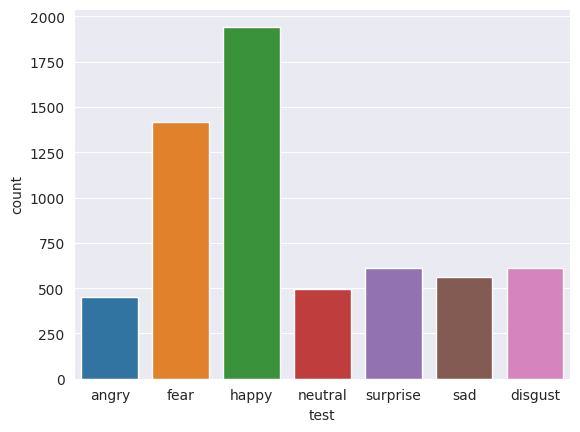

In [90]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame()
df1 = pd.DataFrame()
print(newSet.dataSet.label_list)
print(newSet.getEmotionFromId(true))

df["test"] = newSet.getEmotionFromId(preds)
df1["test"] = newSet.getEmotionFromId(true)
sns.countplot(x ="test", data= df)


<AxesSubplot: xlabel='test', ylabel='count'>

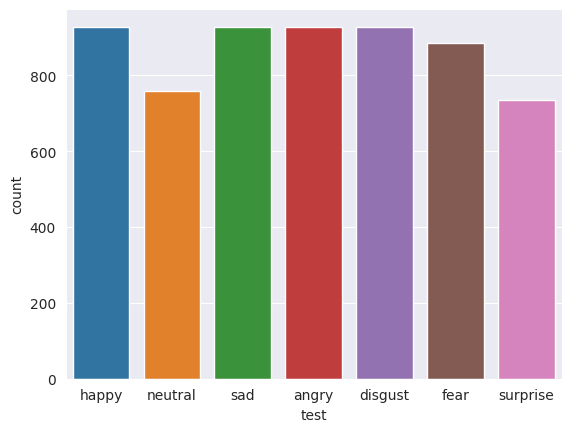

In [62]:
sns.countplot(x ="test", data= df1)

In [84]:
directory_tess="/home/ckwdani/Music/emotionDatasets/unconverted/tess"
directory_cafe="/home/ckwdani/Music/emotionDatasets/converted_mono/cafe"
directory_ravdess="/home/ckwdani/Music/emotionDatasets/converted_mono/RAVDESS Audio_Speech_Actors_01-24"
directory_mesd="/home/ckwdani/Music/emotionDatasets/converted_mono/mesd"
tess = ced.DatasetGeneric(directory=directory_tess, device="cpu", load_dataset=ced.loadTess,)
cafe = ced.DatasetGeneric(directory=directory_cafe, device="cpu", load_dataset=ced.loadCafe,)
ravdess = ced.DatasetGeneric(directory=directory_ravdess, device="cpu", load_dataset=ced.loadRavdess,)
mesd = ced.DatasetGeneric(directory=directory_mesd, device="cpu", load_dataset=ced.loadMesd,)

<AxesSubplot: xlabel='emotion', ylabel='count'>

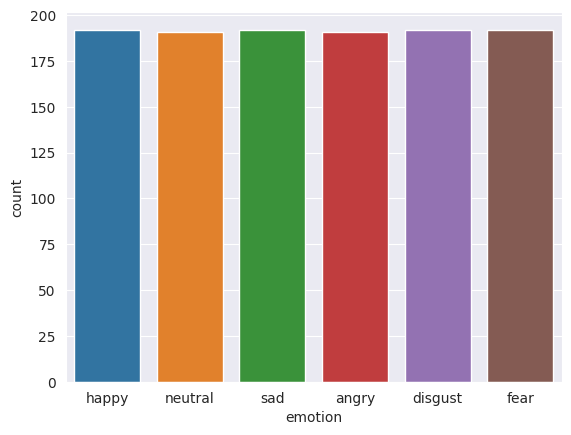

In [85]:
sns.countplot(x=tess.labelcolumn, data=mesd.dataFrame)

<AxesSubplot: xlabel='emotion', ylabel='count'>

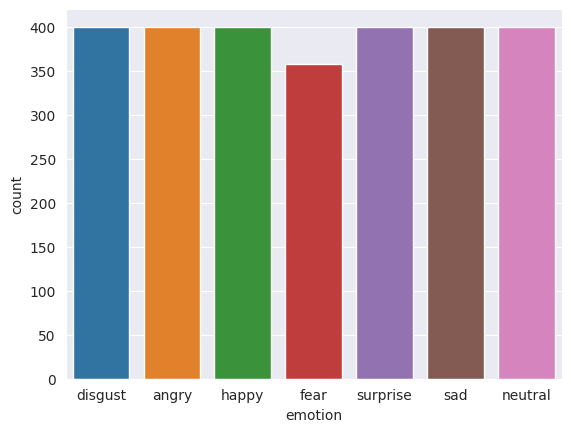

In [86]:
sns.countplot(x=tess.labelcolumn, data=tess.dataFrame)

<AxesSubplot: xlabel='emotion', ylabel='count'>

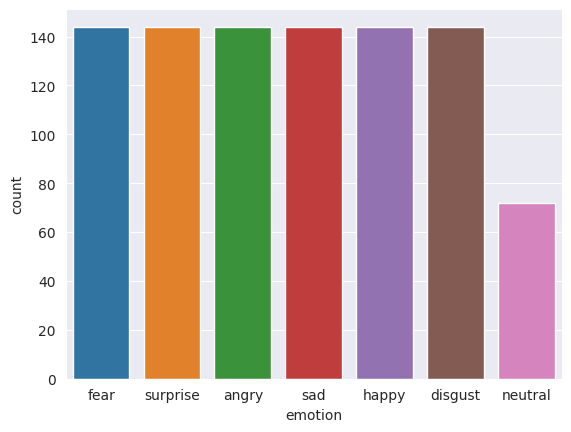

In [82]:
sns.countplot(x=tess.labelcolumn, data=cafe.dataFrame)

<AxesSubplot: xlabel='emotion', ylabel='count'>

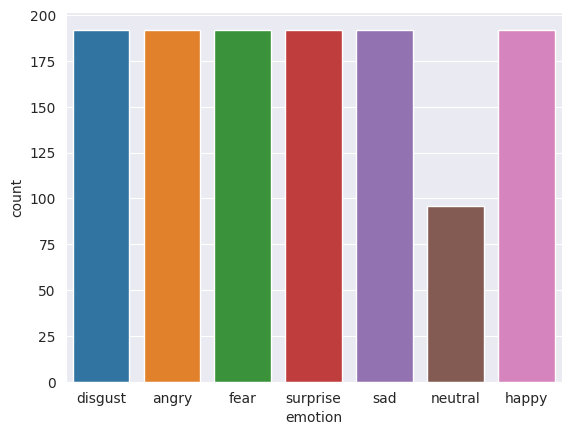

In [87]:
sns.countplot(x=tess.labelcolumn, data=ravdess.dataFrame)

<AxesSubplot: xlabel='emotion', ylabel='count'>

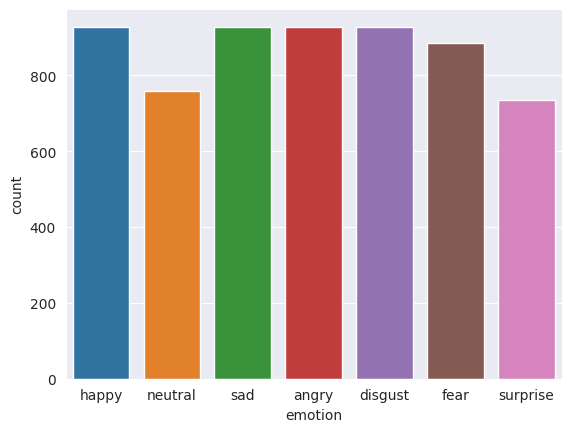

In [88]:
emo_dataset = ced.CombinedEmoDataSet_7_emos(
    directory_tess="/home/ckwdani/Music/emotionDatasets/converted_mono/tess",
    directory_cafe="/home/ckwdani/Music/emotionDatasets/converted_mono/cafe",
    directory_ravdess="/home/ckwdani/Music/emotionDatasets/converted_mono/RAVDESS Audio_Speech_Actors_01-24",
    directory_mesd="/home/ckwdani/Music/emotionDatasets/converted_mono/mesd",
                                             device=device)
sns.countplot(x=emo_dataset.labelcolumn, data=emo_dataset.dataFrame)